# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#SKLearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score, plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


#Yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.features.pca import PCADecomposition

C:\Users\pedro\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\pedro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Displaying all columns

In [2]:
pd.options.display.max_columns = None

# Exploratory Data Analysis

In [3]:
rain = pd.read_csv('./data/rain_data_aus.csv')

In [4]:
rain.shape

(142193, 23)

In [5]:
rain.head()

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,amountOfRain,raintomorrow,temp,humidity,precipitation3pm,precipitation9am,modelo_vigente
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No,29.48,28.400000,12,5.115360,0.089825
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No,32.12,2.208569,10,21.497100,0.023477
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No,32.84,38.000000,17,20.782859,0.027580
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No,35.60,21.200000,8,12.028646,0.023962
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No,40.76,41.600000,9,11.883546,0.220164


In [6]:
rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   date              142193 non-null  object 
 1   location          142193 non-null  object 
 2   mintemp           141556 non-null  float64
 3   maxtemp           141871 non-null  float64
 4   rainfall          140787 non-null  float64
 5   evaporation       81350 non-null   float64
 6   sunshine          74377 non-null   float64
 7   humidity9am       140419 non-null  float64
 8   humidity3pm       138583 non-null  float64
 9   pressure9am       128179 non-null  float64
 10  pressure3pm       128212 non-null  float64
 11  cloud9am          88536 non-null   float64
 12  cloud3pm          85099 non-null   float64
 13  temp9am           141289 non-null  float64
 14  temp3pm           139467 non-null  float64
 15  raintoday         140787 non-null  object 
 16  amountOfRain      14

There are 4 object columns: 

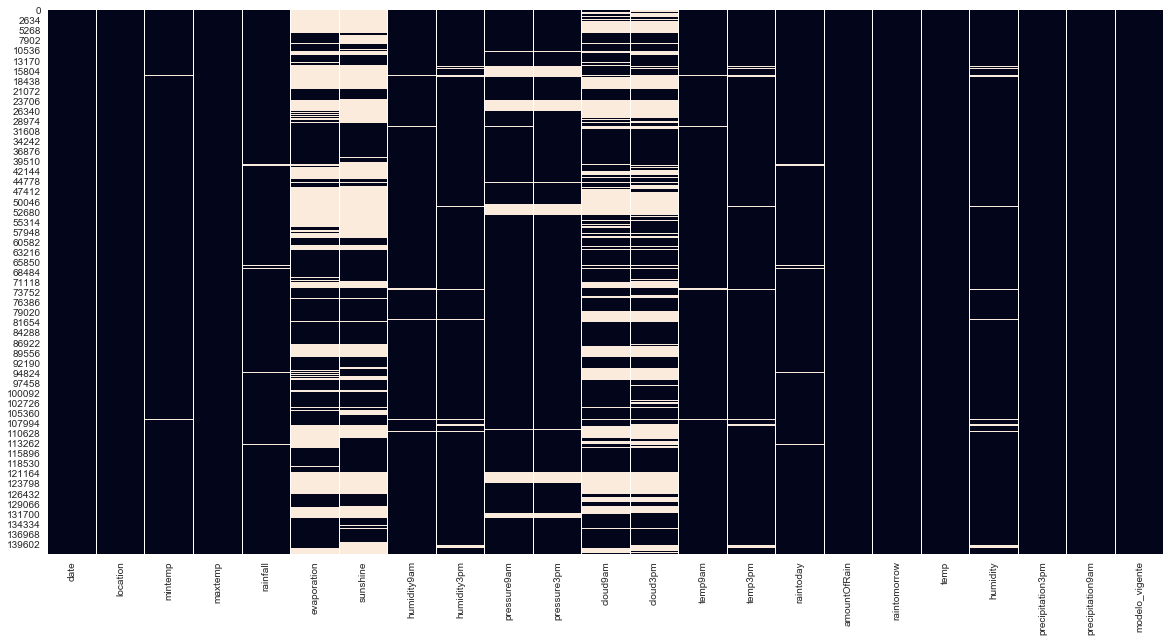

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(rain.isnull(), cbar=False);

In [8]:
rain.select_dtypes(include='object').columns

Index(['date', 'location', 'raintoday', 'raintomorrow'], dtype='object')

Looking for missing values

In [9]:
rain.isnull().sum()

date                    0
location                0
mintemp               637
maxtemp               322
rainfall             1406
evaporation         60843
sunshine            67816
humidity9am          1774
humidity3pm          3610
pressure9am         14014
pressure3pm         13981
cloud9am            53657
cloud3pm            57094
temp9am               904
temp3pm              2726
raintoday            1406
amountOfRain            0
raintomorrow            0
temp                  322
humidity             3610
precipitation3pm        0
precipitation9am        0
modelo_vigente          0
dtype: int64

# Simple Baseline

Then we decided to do a simple baseline so we can run the logistic regression

## Treating missing values

Let's drop the columns with high missing values. We decided to drop the columns that have more than 1/3 of missing values

In [10]:
nan = rain.isnull().sum()
cols_to_drop = []

for i, value in enumerate(nan.values):
    if value > rain.shape[0]/3:
        cols_to_drop.append(nan.index[i])
        
cols_to_drop

['evaporation', 'sunshine', 'cloud9am', 'cloud3pm']

In [11]:
rain = rain.drop(cols_to_drop, axis=1)

In [12]:
rain.shape

(142193, 19)

We also decided to drop 'pressure9am' and 'pressure3pm' columns

In [13]:
#Almost 10% of null values
rain['pressure9am'].isnull().value_counts(normalize=True)

False    0.901444
True     0.098556
Name: pressure9am, dtype: float64

In [14]:
#Almost 10% of null values too
rain['pressure3pm'].isnull().value_counts(normalize=True)

False    0.901676
True     0.098324
Name: pressure3pm, dtype: float64

In [15]:
rain.groupby(by= 'location')[['pressure9am', 'pressure3pm']].describe()

pressure9am                                                   \
                       count         mean       std    min       25%      50%   
location                                                                        
Adelaide              3082.0  1018.727579  7.357987  982.3  1013.700  1018.70   
Albany                2991.0  1018.283049  7.251447  989.2  1013.600  1018.50   
Albury                3011.0  1018.367253  7.361457  989.8  1013.400  1018.40   
AliceSprings          3030.0  1016.699670  6.409189  997.7  1011.725  1016.70   
BadgerysCreek         2785.0  1018.450880  7.014221  996.8  1013.900  1018.60   
Ballarat              3004.0  1017.855293  7.611270  989.4  1012.900  1017.90   
Bendigo               3020.0  1018.024272  7.448458  989.5  1013.000  1018.10   
Brisbane              3161.0  1018.246947  5.461651  997.8  1014.600  1018.30   
Cairns                2988.0  1014.154284  4.183403  994.4  1011.400  1014.70   
Canberra              3194.0  1018.986725  7.492871  987.4  1013.925  1018.90   
Cobar                 2961.0  1017.995137  6.462880  991.7  1013.300  1017.90   
CoffsHarbour          2688.0  1018.222731  6.076822  998.3  1014.100  1018.30   
Dartmoor              2942.0  1017.997621  7.962654  986.2  1012.800  1018.20   
Darwin                3191.0  1011.888154  3.355192  996.3  1009.600  1012.20   
GoldCoast             2980.0  1017.932081  5.457297  999.5  1014.200  1017.90   
Hobart                3187.0  1014.526828  9.964205  982.2  1008.200  1015.40   
Katherine             1558.0  1012.840244  3.797706  998.9  1010.125  1013.00   
Launceston            1882.0  1015.666578  9.238052  985.0  1009.900  1016.35   
Melbourne             2434.0  1017.732580  7.834652  988.9  1012.625  1018.00   
MelbourneAirport      3009.0  1018.087670  7.682523  989.7  1013.100  1018.30   
Mildura               3003.0  1018.771029  7.053044  991.3  1013.900  1018.70   
Moree                 2854.0  1018.309706  5.952067  999.0  1014.000  1018.30   
MountGambier          3029.0  1017.940112  7.934820  985.1  1012.800  1018.20   
MountGinini              0.0          NaN       NaN    NaN       NaN      NaN   
Newcastle                0.0          NaN       NaN    NaN       NaN      NaN   
Nhil                  1569.0  1018.546335  7.543523  986.9  1013.500  1018.50   
NorahHead             2917.0  1018.259033  6.732356  996.5  1013.900  1018.30   
NorfolkIsland         2956.0  1017.631360  5.510219  980.5  1014.200  1018.00   
Nuriootpa             2995.0  1018.915793  7.154657  982.0  1014.100  1018.80   
PearceRAAF            2744.0  1017.746902  6.311765  996.9  1013.200  1017.50   
Penrith                  0.0          NaN       NaN    NaN       NaN      NaN   
Perth                 3192.0  1017.784398  6.523240  996.2  1013.100  1017.40   
PerthAirport          3007.0  1017.890323  6.429501  996.7  1013.300  1017.60   
Portland              2984.0  1017.686260  8.091115  986.7  1012.400  1018.10   
Richmond              2931.0  1018.705527  7.028448  997.0  1014.100  1018.80   
Sale                  2986.0  1017.827294  8.020095  989.3  1012.700  1018.20   
SalmonGums               0.0          NaN       NaN    NaN       NaN      NaN   
Sydney                3317.0  1018.346156  7.021571  986.7  1013.700  1018.60   
SydneyAirport         2997.0  1018.360594  6.979996  996.3  1013.800  1018.50   
Townsville            3033.0  1015.173129  4.590418  994.3  1012.000  1015.60   
Tuggeranong           2983.0  1018.521623  7.571827  992.8  1013.300  1018.40   
Uluru                 1518.0  1017.109881  6.437819  994.6  1012.300  1017.10   
WaggaWagga            2976.0  1018.569120  7.077536  991.5  1013.700  1018.40   
Walpole               2817.0  1017.845651  7.099440  988.9  1013.300  1018.10   
Watsonia              2999.0  1018.035178  7.701749  989.7  1012.950  1018.20   
Williamtown           2543.0  1018.365906  6.579661  997.8  1014.000  1018.50   
Witchcliffe           2819.0  1018.473643  6.701

Grouping by location we can see that some cities do not record the values of these features. Despite the possible relevance of these features, we decided to drop the columns to make a baseline and later we will check these columns. We chose to drop the columns instead of the rows because by dropping the rows we could lose all values for those cities.

In [16]:
rain = rain.drop(['pressure9am','pressure3pm'], axis=1)

Now let's drop the rows that contain missing values

In [17]:
rain = rain.dropna()

In [18]:
rain.shape

(136489, 17)

Let's check if there are still any missing values

In [19]:
rain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136489 entries, 0 to 142192
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   date              136489 non-null  object 
 1   location          136489 non-null  object 
 2   mintemp           136489 non-null  float64
 3   maxtemp           136489 non-null  float64
 4   rainfall          136489 non-null  float64
 5   humidity9am       136489 non-null  float64
 6   humidity3pm       136489 non-null  float64
 7   temp9am           136489 non-null  float64
 8   temp3pm           136489 non-null  float64
 9   raintoday         136489 non-null  object 
 10  amountOfRain      136489 non-null  float64
 11  raintomorrow      136489 non-null  object 
 12  temp              136489 non-null  float64
 13  humidity          136489 non-null  float64
 14  precipitation3pm  136489 non-null  int64  
 15  precipitation9am  136489 non-null  float64
 16  modelo_vigente    13

## Treating object columns

In [20]:
rain.select_dtypes(include='object').columns

Index(['date', 'location', 'raintoday', 'raintomorrow'], dtype='object')

Transform date into datetime values

In [21]:
rain['date'] = pd.to_datetime(rain.date)

Transform binary values of 'raintoday' and 'raintomorrow' into 0 and 1

In [22]:
rain['raintoday'] = rain.raintoday.apply(lambda x: 0 if x == 'No' else 1)

In [23]:
rain['raintomorrow'] = rain.raintomorrow.apply(lambda x: 0 if x == 'No' else 1)

In [24]:
rain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136489 entries, 0 to 142192
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              136489 non-null  datetime64[ns]
 1   location          136489 non-null  object        
 2   mintemp           136489 non-null  float64       
 3   maxtemp           136489 non-null  float64       
 4   rainfall          136489 non-null  float64       
 5   humidity9am       136489 non-null  float64       
 6   humidity3pm       136489 non-null  float64       
 7   temp9am           136489 non-null  float64       
 8   temp3pm           136489 non-null  float64       
 9   raintoday         136489 non-null  int64         
 10  amountOfRain      136489 non-null  float64       
 11  raintomorrow      136489 non-null  int64         
 12  temp              136489 non-null  float64       
 13  humidity          136489 non-null  float64       
 14  prec

Location columns:

In [25]:
rain['location'].value_counts()

Canberra            3328
Sydney              3308
Darwin              3188
Perth               3180
Hobart              3164
Brisbane            3120
Townsville          3026
Bendigo             3022
AliceSprings        3018
Adelaide            3012
PerthAirport        3008
Launceston          3006
MountGambier        3005
Mildura             3000
MelbourneAirport    2999
SydneyAirport       2997
Ballarat            2993
Albury              2981
Watsonia            2972
Sale                2967
Cairns              2963
Nuriootpa           2962
WaggaWagga          2955
Woomera             2950
Tuggeranong         2943
NorfolkIsland       2937
SalmonGums          2934
Wollongong          2926
Portland            2919
CoffsHarbour        2917
GoldCoast           2913
NorahHead           2875
Richmond            2863
Cobar               2860
Penrith             2844
BadgerysCreek       2842
Moree               2783
Dartmoor            2770
Walpole             2726
Witchcliffe         2678


We will deal with the 'location' column later

## Baseline Model

### Logistic Regression Model

We decided to make a baseline first with all the columns and applying a logistic regression.

In [26]:
model = LogisticRegression(n_jobs= -1)

### Divide Train X Test

In [27]:
y = rain['raintomorrow']

In [28]:
X = rain[['mintemp', 'maxtemp', 'rainfall', 'humidity9am',
       'humidity3pm', 'temp9am', 'temp3pm', 'amountOfRain',
       'temp', 'humidity', 'precipitation3pm', 'precipitation9am']]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

### Training Model

In [30]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
model.predict(X_train)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [32]:
model.predict(X_test)

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [33]:
model.predict_proba(X_test)

array([[1.00000000e+00, 2.57870406e-10],
       [9.99999998e-01, 1.92534962e-09],
       [9.99999985e-01, 1.48931038e-08],
       ...,
       [0.00000000e+00, 1.00000000e+00],
       [9.99982352e-01, 1.76479925e-05],
       [9.99999997e-01, 3.20151321e-09]])

### Accuracy Score

In [34]:
baseline_score = model.score(X_test, y_test)
baseline_score

0.9959704007619605

In [35]:
model.score(X_train, y_train)

0.9956864576750831

The score is too high! What's happening? Let's explore:

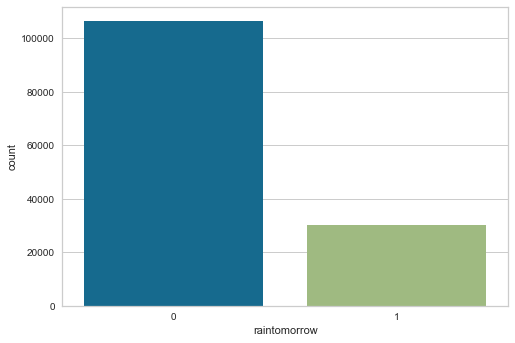

In [36]:
sns.countplot(rain['raintomorrow'])

### Confusion Matrix

In [37]:
confusion_matrix(y_test, model.predict(X_test))

array([[21249,    46],
       [   64,  5939]], dtype=int64)

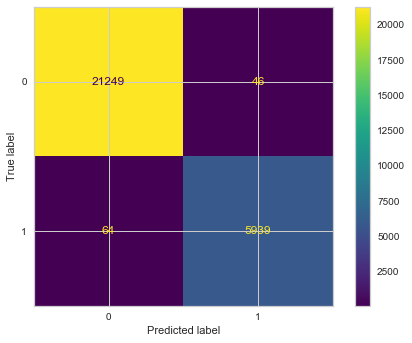

In [38]:
plot_confusion_matrix(model, X_test, y_test, values_format='.0f')

Recall X Precision

In [39]:
baseline_precision = precision_score(y_test, model.predict(X_test))
baseline_precision

0.9923141186299081

In [40]:
baseline_recall = recall_score(y_test, model.predict(X_test))
baseline_recall

0.9893386640013326

Roc Curve

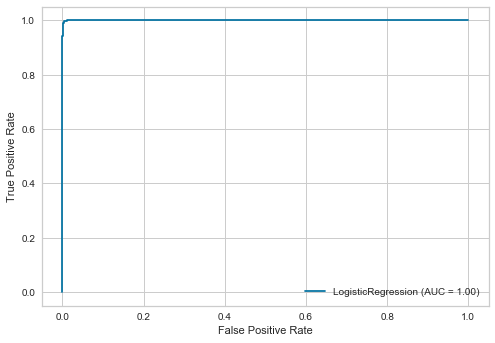

In [41]:
plot_roc_curve(model, X_test, y_test);

The AUC is also too high

### Investigating further

In [42]:
X_test.columns

Index(['mintemp', 'maxtemp', 'rainfall', 'humidity9am', 'humidity3pm',
       'temp9am', 'temp3pm', 'amountOfRain', 'temp', 'humidity',
       'precipitation3pm', 'precipitation9am'],
      dtype='object')

Importância de cada variável usada no modelo:

In [43]:
list(zip(list(X.columns), list(model.coef_[0])))

[('mintemp', 0.3550370996389116),
 ('maxtemp', -0.3466592631598441),
 ('rainfall', 0.009116481706666613),
 ('humidity9am', -0.06909502437812896),
 ('humidity3pm', -0.05872191950488647),
 ('temp9am', -0.1724352501822587),
 ('temp3pm', 0.0062879944974473315),
 ('amountOfRain', 17.23015145462481),
 ('temp', -3.828696433501224e-05),
 ('humidity', -0.0024619580833508464),
 ('precipitation3pm', -0.24535394918662684),
 ('precipitation9am', -0.08127572691255971)]

The feature 'amountOfRain' explains basically by itself the target 'raintomorrow'. We are leaking the data about tomorrow. In "real life" we woudn't have the column "RainTomorrow" if we wanted to predict if it's going to rain tomorrow.

## Scores DataFrame

Let's create a DataFrame to store every scores we get by testing some models

In [44]:
def scores(Column, score, precision, recall):
    '''
    Append a new colum of scores into a dataframe of scores, use it to compare your models.
    
    Columns: Name of the columns/model
    score: Accuracy score
    precision: Precision Score
    recall: Recall Score
    '''
    
    df = pd.DataFrame({Column : [score,precision,recall]}, index=['SCORE', 'PRECISION', 'RECALL'])
    x = pd.concat([rain_scores, df], axis = 1)
    return x

### Storing Baseline Scores

In [45]:
rain_scores = pd.DataFrame({'Baseline (Log. Regression)' : [baseline_score,baseline_precision, baseline_recall]}, index=['SCORE', 'PRECISION', 'RECALL'])
rain_scores

,Baseline (Log. Regression)
SCORE,0.995970
PRECISION,0.992314
RECALL,0.989339


## Standardize Data

In [46]:
from sklearn.preprocessing import StandardScaler

In [47]:
scaler = StandardScaler()

In [48]:
X_std = scaler.fit_transform(X)

In [49]:
X_std = pd.DataFrame(X_std, columns=X.columns)

# Baseline Model 2

## Logistic Regression Model Without 'amountOfRain'

In [50]:
y = rain['raintomorrow']

In [51]:
X_2 = X_std[['humidity9am', 'humidity3pm', 'temp9am', 'rainfall',
             'temp3pm', 'precipitation3pm', 'precipitation9am']]

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

In [53]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
model.predict(X_train)

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [55]:
model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [56]:
model.predict_proba(X_test)

array([[0.93495853, 0.06504147],
       [0.77049493, 0.22950507],
       [0.98047341, 0.01952659],
       ...,
       [0.69695575, 0.30304425],
       [0.50074457, 0.49925543],
       [0.96810529, 0.03189471]])

In [57]:
baseline2_score = model.score(X_test, y_test)
baseline2_score

0.8344201040369258

In [58]:
model.score(X_train, y_train)

0.8328433662115009

Without the "amountOfRain" feature we got a more realistic score.

### Confusion Matrix

In [59]:
confusion_matrix(y_test, model.predict(X_test))

array([[20456,   839],
       [ 3681,  2322]], dtype=int64)

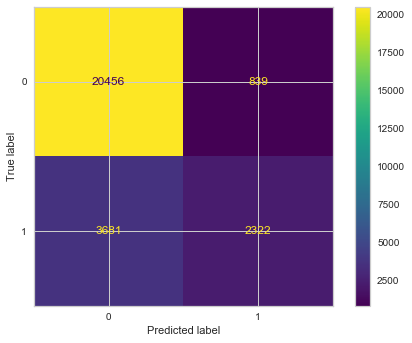

In [60]:
plot_confusion_matrix(model, X_test, y_test, values_format='.0f')

### Precision X Recall

Precision:

In [61]:
precision2_score = precision_score(y_test, model.predict(X_test))
precision2_score

0.7345776652957925

Recall:

In [62]:
recall2_score = recall_score(y_test, model.predict(X_test))
recall2_score

0.3868065967016492

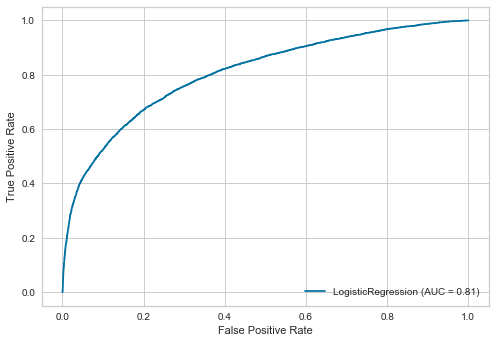

In [63]:
plot_roc_curve(model, X_test, y_test)

In [64]:
list(zip(list(X_2.columns), list(model.coef_[0])))

[('humidity9am', 0.02222601624887074),
 ('humidity3pm', 1.2155828731665648),
 ('temp9am', 0.35699563485172137),
 ('rainfall', 0.3227663896182043),
 ('temp3pm', -0.26656427666405264),
 ('precipitation3pm', 0.017384867001949942),
 ('precipitation9am', -0.01848696242245492)]

In [65]:
rain.head()

,date,location,mintemp,maxtemp,rainfall,humidity9am,humidity3pm,temp9am,temp3pm,raintoday,amountOfRain,raintomorrow,temp,humidity,precipitation3pm,precipitation9am,modelo_vigente
0,2008-12-01,Albury,13.4,22.9,0.6,71.0,22.0,16.9,21.8,0,0.0,0,29.48,28.400000,12,5.115360,0.089825
1,2008-12-02,Albury,7.4,25.1,0.0,44.0,25.0,17.2,24.3,0,0.0,0,32.12,2.208569,10,21.497100,0.023477
2,2008-12-03,Albury,12.9,25.7,0.0,38.0,30.0,21.0,23.2,0,0.0,0,32.84,38.000000,17,20.782859,0.027580
3,2008-12-04,Albury,9.2,28.0,0.0,45.0,16.0,18.1,26.5,0,1.0,0,35.60,21.200000,8,12.028646,0.023962
4,2008-12-05,Albury,17.5,32.3,1.0,82.0,33.0,17.8,29.7,0,0.2,0,40.76,41.600000,9,11.883546,0.220164


## Comparing Models

In [66]:
rain_scores = scores('Baseline 2 (Log. Regression)', baseline2_score, precision2_score, recall2_score)
rain_scores

,Baseline (Log. Regression),Baseline 2 (Log. Regression)
SCORE,0.995970,0.834420
PRECISION,0.992314,0.734578
RECALL,0.989339,0.386807


# Rain + Wind

In [67]:
rain = pd.read_csv('./data/rain_data_aus.csv')
wind = pd.DataFrame()
for i in range(1,9):
    df_aux = pd.read_csv(f'./data/wind_table_0{i}.csv')
    df_aux.columns = ['date', 'location', 'wind_gustdir', 'wind_gustspeed', 'wind_dir9am',
       'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']
    wind = pd.concat([wind,df_aux])
rain_wind =  pd.merge(rain, wind, how='left', on=['date', 'location'])

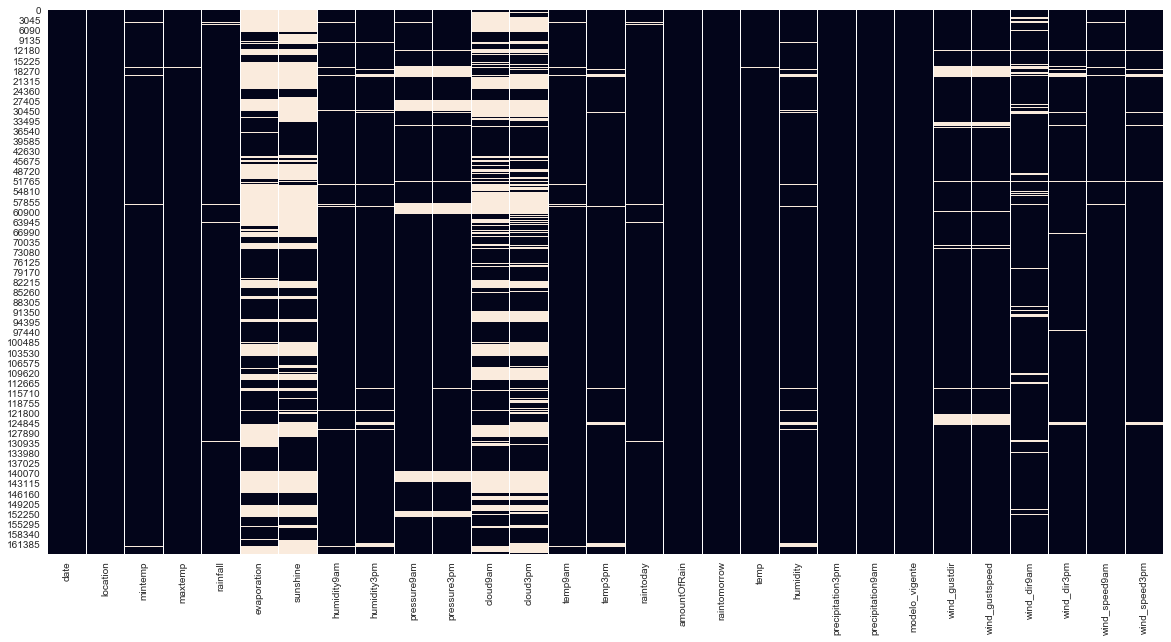

In [68]:
#Heatmap of nulls
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(rain_wind.isnull(), cbar=False);

In [69]:
#Droping columns and rows again
rain_wind.drop(['evaporation', 'sunshine', 'pressure9am', 'pressure3pm', 'cloud9am', 'cloud3pm'], axis = 1, inplace = True)
rain_wind.dropna(axis=0, inplace=True)

In [70]:
X = rain_wind[['rainfall', 'humidity9am', 'humidity3pm',
       'temp9am', 'temp3pm', 'precipitation3pm', 'precipitation9am',
        'wind_speed9am','wind_speed3pm']]

## Standardize Data

In [71]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [72]:
rain_wind['raintomorrow'] = rain_wind['raintomorrow'].apply(lambda x: 0 if x == 'No' else 1)

In [73]:
y = rain_wind['raintomorrow']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

model.fit(X_train, y_train)
model.predict(X_train)
model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [75]:
model.predict_proba(X_test)

array([[0.95081228, 0.04918772],
       [0.81467153, 0.18532847],
       [0.52799775, 0.47200225],
       ...,
       [0.73096056, 0.26903944],
       [0.87668775, 0.12331225],
       [0.71018026, 0.28981974]])

In [76]:
wind_score = model.score(X_test, y_test)
wind_score

0.8295688614248171

In [77]:
model.score(X_train, y_train)

0.8334724318565213

In [78]:
wind_precision = precision_score(y_test, model.predict(X_test))
wind_precision

0.7166713840928389

In [79]:
wind_recall = recall_score(y_test, model.predict(X_test))
wind_recall

0.4

## Confusion Matrix

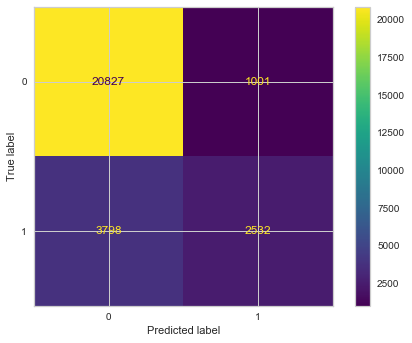

In [80]:
plot_confusion_matrix(model, X_test, y_test, values_format='.0f')

## Comparing Models

In [81]:
rain_scores = scores('Model 3 + Wind Speed (Log. Regression)', wind_score, wind_precision, wind_recall)
rain_scores

,Baseline (Log. Regression),Baseline 2 (Log. Regression),Model 3 + Wind Speed (Log. Regression)
SCORE,0.995970,0.834420,0.829569
PRECISION,0.992314,0.734578,0.716671
RECALL,0.989339,0.386807,0.400000


# Rain + Wind 2

In [82]:
rain = pd.read_csv('./data/rain_data_aus.csv')
wind = pd.DataFrame()
for i in range(1,9):
    df_aux = pd.read_csv(f'./data/wind_table_0{i}.csv')
    df_aux.columns = ['date', 'location', 'wind_gustdir', 'wind_gustspeed', 'wind_dir9am',
       'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']
    wind = pd.concat([wind,df_aux])
rain_wind =  pd.merge(rain, wind, how='left', on=['date', 'location'])

Checking if there are dupplicated rows

In [83]:
rain_wind.duplicated().sum()

22193

In [84]:
rain_wind.shape

(164386, 29)

Droping duplicated rows

In [85]:
rain_wind.drop_duplicates(inplace=True)

In [86]:
rain_wind.shape

(142193, 29)

## Cleaning Dataset

### Treating object columns

Transform binary values of 'raintoday' and 'raintomorrow' into 0 and 1

In [87]:
rain_wind['raintoday'] = rain_wind['raintoday'].apply(lambda x: 0 if x == 'No' else 1)

In [88]:
rain_wind['raintomorrow'] = rain_wind['raintomorrow'].apply(lambda x: 0 if x == 'No' else 1)

Drop 'amountOfRain' column, because we won't use it in the model

In [89]:
rain_wind = rain_wind.drop(columns='amountOfRain')

Datetime column:

In [90]:
rain_wind['date'] = pd.to_datetime(rain_wind['date'])

Creating the columns: day, month, year separately

In [91]:
rain_wind['day'] = rain_wind['date'].dt.day

In [92]:
rain_wind['month'] = rain_wind['date'].dt.month

In [93]:
rain_wind['year'] = rain_wind['date'].dt.year

Drop the column 'date', because we don't need it anymore

In [94]:
rain_wind = rain_wind.drop(columns='date')

Get Dummies on the categorical features

In [95]:
rain_wind = pd.concat([rain_wind, pd.get_dummies(rain_wind['location'], prefix='loc')], axis=1)

In [96]:
rain_wind = pd.concat([rain_wind, pd.get_dummies(rain_wind['wind_dir9am'], prefix='wind_dir9am')], axis=1)

In [97]:
rain_wind = pd.concat([rain_wind, pd.get_dummies(rain_wind['wind_dir3pm'], prefix='wind_dir3pm')], axis=1)

Dropping columns:

In [98]:
rain_wind = rain_wind.drop(columns=['location', 'wind_dir9am', 'wind_dir3pm', 'evaporation', 'sunshine', 'wind_gustdir',
                                   'mintemp', 'maxtemp', 'raintoday', 'temp', 'humidity', 'modelo_vigente', 'wind_gustspeed',
                                   'cloud3pm', 'cloud9am'])

In [99]:
rain_wind.shape

(142193, 96)

In [100]:
rain_wind = rain_wind.dropna()

In [101]:
rain_wind.shape

(124105, 96)

## Logistic Regression

In [102]:
logistic = LogisticRegression(n_jobs=-1)

In [103]:
rain_wind.head()

,rainfall,humidity9am,humidity3pm,pressure9am,pressure3pm,temp9am,temp3pm,raintomorrow,precipitation3pm,precipitation9am,wind_speed9am,wind_speed3pm,day,month,year,loc_Adelaide,loc_Albany,loc_Albury,loc_AliceSprings,loc_BadgerysCreek,loc_Ballarat,loc_Bendigo,loc_Brisbane,loc_Cairns,loc_Canberra,loc_Cobar,loc_CoffsHarbour,loc_Dartmoor,loc_Darwin,loc_GoldCoast,loc_Hobart,loc_Katherine,loc_Launceston,loc_Melbourne,loc_MelbourneAirport,loc_Mildura,loc_Moree,loc_MountGambier,loc_MountGinini,loc_Newcastle,loc_Nhil,loc_NorahHead,loc_NorfolkIsland,loc_Nuriootpa,loc_PearceRAAF,loc_Penrith,loc_Perth,loc_PerthAirport,loc_Portland,loc_Richmond,loc_Sale,loc_SalmonGums,loc_Sydney,loc_SydneyAirport,loc_Townsville,loc_Tuggeranong,loc_Uluru,loc_WaggaWagga,loc_Walpole,loc_Watsonia,loc_Williamtown,loc_Witchcliffe,loc_Wollongong,loc_Woomera,wind_dir9am_E,wind_dir9am_ENE,wind_dir9am_ESE,wind_dir9am_N,wind_dir9am_NE,wind_dir9am_NNE,wind_dir9am_NNW,wind_dir9am_NW,wind_dir9am_S,wind_dir9am_SE,wind_dir9am_SSE,wind_dir9am_SSW,wind_dir9am_SW,wind_dir9am_W,wind_dir9am_WNW,wind_dir9am_WSW,wind_dir3pm_E,wind_dir3pm_ENE,wind_dir3pm_ESE,wind_dir3pm_N,wind_dir3pm_NE,wind_dir3pm_NNE,wind_dir3pm_NNW,wind_dir3pm_NW,wind_dir3pm_S,wind_dir3pm_SE,wind_dir3pm_SSE,wind_dir3pm_SSW,wind_dir3pm_SW,wind_dir3pm_W,wind_dir3pm_WNW,wind_dir3pm_WSW
0,0.6,71.0,22.0,1007.7,1007.1,16.9,21.8,0,12,5.115360,20.0,24.0,1,12,2008,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0,10,21.497100,4.0,22.0,2,12,2008,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0,17,20.782859,19.0,26.0,3,12,2008,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0,8,12.028646,11.0,9.0,4,12,2008,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0,9,11.883546,7.0,20.0,5,12,2008,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [104]:
y = rain_wind['raintomorrow']
X = rain_wind.loc[:, rain_wind.columns!='raintomorrow']

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify=y)

In [106]:
logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [107]:
logistic.score(X_train, y_train)

0.8398029894041336

In [108]:
wind_score = logistic.score(X_test, y_test)
wind_score

0.8366705612183232

In [109]:
wind_precision = precision_score(y_test, logistic.predict(X_test))
wind_precision

0.715792646172393

In [110]:
wind_recall = recall_score(y_test, logistic.predict(X_test))
wind_recall

0.43292016040831205

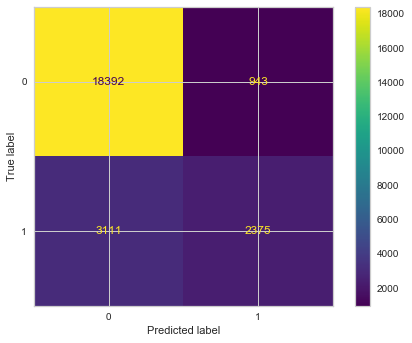

In [111]:
plot_confusion_matrix(logistic, X_test, y_test, values_format='.0f')

In [112]:
rain_scores = scores('Model 4 + Wind Speed (Log. Regression)', wind_score, wind_precision, wind_recall)
rain_scores

,Baseline (Log. Regression),Baseline 2 (Log. Regression),Model 3 + Wind Speed (Log. Regression),Model 4 + Wind Speed (Log. Regression)
SCORE,0.995970,0.834420,0.829569,0.836671
PRECISION,0.992314,0.734578,0.716671,0.715793
RECALL,0.989339,0.386807,0.400000,0.432920


# Random Forest

In [113]:
y = rain_wind['raintomorrow']
X = rain_wind.loc[:, rain_wind.columns!='raintomorrow']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify=y)

In [115]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth=5, n_estimators=200, n_jobs=-1)

In [116]:
from sklearn.model_selection import cross_val_score, KFold
results = cross_val_score(forest, X_train, y_train, cv=KFold(3, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.8366346454866767, 0.003836853157231356)

In [117]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [118]:
wind_score = forest.score(X_test, y_test)
wind_score

0.8100801740461706

In [119]:
score_recall = recall_score(y_test, forest.predict(X_test))
score_recall

0.16715275246080932

In [120]:
score_precision = precision_score(y_test, forest.predict(X_test))
score_precision

0.8634651600753296

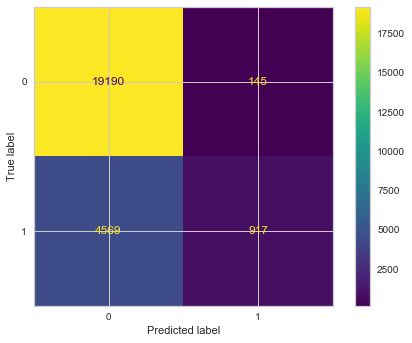

In [121]:
plot_confusion_matrix(forest, X_test, y_test, values_format='.0f')

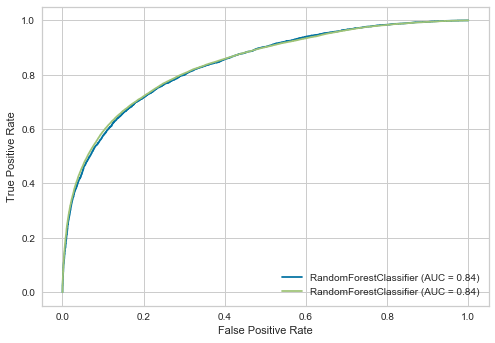

In [122]:
fig, ax = plt.subplots()

plot_roc_curve(forest, X_test, y_test, ax=ax)
plot_roc_curve(forest, X_train, y_train, ax=ax)

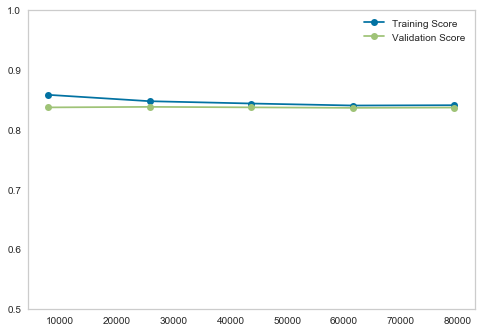

In [123]:
from sklearn.model_selection import learning_curve
curves = learning_curve(forest, X_train, y_train, scoring='roc_auc')

train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]

plt.plot(train_sizes, train_scores.mean(axis=1),'-o', label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1),'-o', label='Validation Score');
plt.ylim([0.5, 1])
plt.legend()
plt.grid()

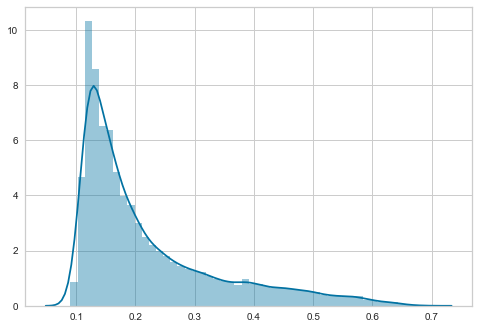

In [124]:
sns.distplot(forest.predict_proba(X_test)[:,1])

In [125]:
y_pred = forest.predict_proba(X_test)[:,1] > 0.3

In [126]:
confusion_matrix(y_test, y_pred)

array([[17414,  1921],
       [ 2334,  3152]], dtype=int64)

In [127]:
rain_wind[['precipitation3pm', 'precipitation9am']].describe()

,precipitation3pm,precipitation9am
count,124105.000000,124105.000000
mean,10.016824,10.002394
std,3.171637,4.999267
min,0.000000,-17.739346
25%,8.000000,6.652184
50%,10.000000,9.998280
75%,12.000000,13.390655
max,26.000000,32.478590


In [128]:
from sklearn.metrics import plot_precision_recall_curve

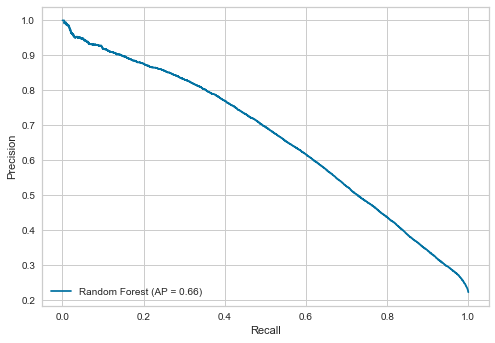

In [129]:
plot_precision_recall_curve(forest, X, y, name='Random Forest')

In [130]:
rain_scores = scores('Model 5 - Random Forest', wind_score, score_precision, score_recall)
rain_scores

,Baseline (Log. Regression),Baseline 2 (Log. Regression),Model 3 + Wind Speed (Log. Regression),Model 4 + Wind Speed (Log. Regression),Model 5 - Random Forest
SCORE,0.995970,0.834420,0.829569,0.836671,0.810080
PRECISION,0.992314,0.734578,0.716671,0.715793,0.863465
RECALL,0.989339,0.386807,0.400000,0.432920,0.167153


#  Decision Tree

In [131]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score,KFold

In [132]:
y=rain_wind['raintomorrow']
X=rain_wind.drop(columns=['raintomorrow'])

In [133]:
model = DecisionTreeClassifier(max_depth=5,ccp_alpha=0.001)

In [134]:
cross_val_score(model, X, y, cv=KFold(10, shuffle=True), scoring='roc_auc')

array([0.81331208, 0.81563552, 0.81283698, 0.80359778, 0.81666984,
       0.80839496, 0.81693981, 0.8071281 , 0.80289318, 0.81167521])

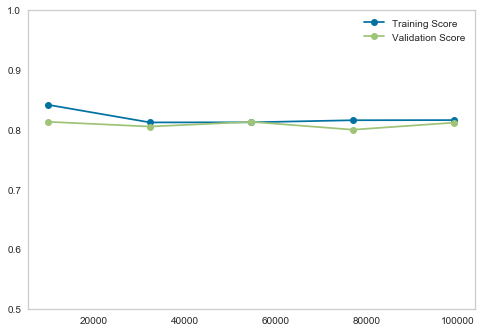

In [135]:
from sklearn.model_selection import learning_curve
curves = learning_curve(model, X, y, scoring='roc_auc')

train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]

plt.plot(train_sizes, train_scores.mean(axis=1),'-o', label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1),'-o', label='Validation Score');
plt.ylim([0.5, 1])
plt.legend()
plt.grid()

In [136]:
model.fit(X,y)

DecisionTreeClassifier(ccp_alpha=0.001, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

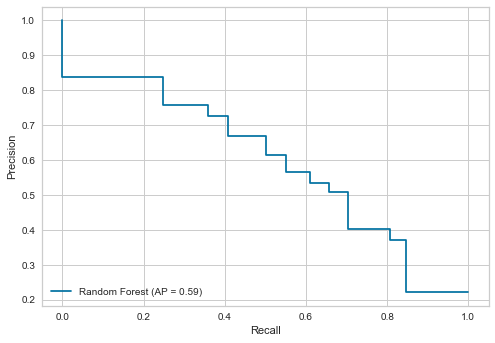

In [137]:
plot_precision_recall_curve(model, X, y, name='Random Forest')

In [138]:
score=model.score(X,y)

In [139]:
score_recall = recall_score(y, model.predict(X))
score_recall

0.407130618643141

In [140]:
precision_recall = precision_score(y, model.predict(X))
precision_recall

0.725666016894087

In [141]:
rain_scores = scores('Model 6 - Decision Tree', score, precision_recall, score_recall)
rain_scores

,Baseline (Log. Regression),Baseline 2 (Log. Regression),Model 3 + Wind Speed (Log. Regression),Model 4 + Wind Speed (Log. Regression),Model 5 - Random Forest,Model 6 - Decision Tree
SCORE,0.995970,0.834420,0.829569,0.836671,0.810080,0.834938
PRECISION,0.992314,0.734578,0.716671,0.715793,0.863465,0.725666
RECALL,0.989339,0.386807,0.400000,0.432920,0.167153,0.407131
